# Variables

In [1]:
YOUR_NAME = 'sara'

AWS_PROFILE = 'cities'

'''
# List of cities to process
cities = ["Belo Horizonte", "Campinas"]#, "Bogota", "Nairobi", "Bamako", 
        #"Lagos", "Accra", "Abidjan", "Mogadishu", "Cape Town", 
        #"Maputo", "Luanda"]

test_cities = ["Belo Horizonte"]
#cities = test_cities

cities = [city.replace(' ', '_') for city in cities]

search_buffer_files = fs.ls(SEARCH_BUFFER_PATH)

cities 

number_of_cities = len(cities)

print(f'City count: {number_of_cities}')
'''
grid_size = 200


# Setup

In [2]:
%load_ext autoreload

In [3]:
MAIN_PATH = "s3://wri-cities-sandbox/identifyingLandSubdivisions/data"
INPUT_PATH = f'{MAIN_PATH}/input'
CITY_INFO_PATH = f'{INPUT_PATH}/city_info'
EXTENTS_PATH = f'{CITY_INFO_PATH}/extents'
BUILDINGS_PATH = f'{INPUT_PATH}/buildings'
BUILDINGS_DISTANCES_PATH = f'{INPUT_PATH}/buildings_with_distances'
ROADS_PATH = f'{INPUT_PATH}/roads'
INTERSECTIONS_PATH = f'{INPUT_PATH}/intersections'
GRIDS_PATH = f'{INPUT_PATH}/city_info/grids'
SEARCH_BUFFER_PATH = f'{INPUT_PATH}/city_info/search_buffers'
BLOCKS_PATH = f'{INPUT_PATH}/blocks'
OUTPUT_PATH = f'{MAIN_PATH}/output'
OUTPUT_PATH_CSV = f'{OUTPUT_PATH}/csv'
OUTPUT_PATH_RASTER = f'{OUTPUT_PATH}/raster'
OUTPUT_PATH_PNG = f'{OUTPUT_PATH}/png'
OUTPUT_PATH_RAW = f'{OUTPUT_PATH}/raw_results'

In [4]:
# Check s3 connection using AWS_PROFILE=CitiesUserPermissionSet profile 
import boto3

session = boto3.Session(profile_name=AWS_PROFILE)
s3 = session.client('s3')

# export CitiesUserPermissionSet profile to use in the next cells
import os
os.environ['AWS_PROFILE'] = AWS_PROFILE


s3.list_buckets()

{'ResponseMetadata': {'RequestId': 'F62522GEAWZPC7AT',
  'HostId': 'hxY+SIz4/FYIgyjAjPOwwJTka4LDIu7v/E8MRUAtsIpivJeblJj15eSLdlZT8xByvUQVgelb+Bw=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'hxY+SIz4/FYIgyjAjPOwwJTka4LDIu7v/E8MRUAtsIpivJeblJj15eSLdlZT8xByvUQVgelb+Bw=',
   'x-amz-request-id': 'F62522GEAWZPC7AT',
   'date': 'Thu, 27 Mar 2025 21:52:18 GMT',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Buckets': [{'Name': 'aft-sandbox-540362055257',
   'CreationDate': datetime.datetime(2022, 9, 13, 15, 12, 20, tzinfo=tzutc())},
  {'Name': 'amplify-citiesindicatorsapi-dev-10508-deployment',
   'CreationDate': datetime.datetime(2023, 8, 30, 5, 5, 13, tzinfo=tzutc())},
  {'Name': 'cities-dev-sandbox',
   'CreationDate': datetime.datetime(2025, 2, 7, 23, 18, 12, tzinfo=tzutc())},
  {'Name': 'cities-heat',
   'CreationDate': datetime.datetime(2023, 6, 1, 13, 22, 1, tzinfo=tzutc())},
  {'Name': 'era5-bra

In [5]:
import coiled

cluster = coiled.Cluster(
    workspace="wri-cities-data",
    name=f'ils-{YOUR_NAME}',
    region="us-west-2",
    arm=True,
    worker_vm_types="r8g.xlarge",
    spot_policy="spot",
    n_workers=8,
    package_sync_ignore=["pyspark", "pypandoc"]
)
client = cluster.get_client()

print(f"Started a new Dask client on Coiled. Dashboard is available at {client.dashboard_link}")


[2025-03-27 16:52:22,045][INFO    ][coiled] Fetching latest package priorities...
[2025-03-27 16:52:22,046][INFO    ][coiled.package_sync] Resolving your local subdivisions2 Python environment...
[2025-03-27 16:52:22,937][INFO    ][coiled.package_sync] Scanning 444 conda packages...
[2025-03-27 16:52:22,945][INFO    ][coiled.package_sync] Scanning 259 python packages...
[2025-03-27 16:52:23,735][INFO    ][coiled] Running pip check...
[2025-03-27 16:52:25,215][INFO    ][coiled] Validating environment...
[2025-03-27 16:52:27,434][INFO    ][coiled] Creating wheel for ~/Documents/Identifying Land Subdivisions/identifyingLandSubdivisions...
[2025-03-27 16:52:27,713][WARNING ][coiled.package_sync] Package - libopenvino-intel-cpu-plugin, libopenvino-intel-cpu-plugin~=2025.0.0 has no install candidate for Python 3.12 linux-aarch64 on conda-forge
[2025-03-27 16:52:27,714][INFO    ][coiled] Uploading coiled_local_identifyingLandSubdivisions...
[2025-03-27 16:52:28,636][INFO    ][coiled] Requesti

Started a new Dask client on Coiled. Dashboard is available at https://cluster-pwsua.dask.host/GSUq14YS9YNiASnN/status


# RUN

In [6]:
import dask_geopandas as dgpd
import geopandas as gpd
from shapely.geometry import shape, Point, LineString, Polygon, MultiPolygon, MultiLineString
from shapely.geometry.base import BaseGeometry
from shapely.strtree import STRtree
from shapely.errors import ShapelyError
import dask
from dask import delayed
import pandas as pd
import numpy as np
from shapely.wkb import loads as wkb_loads
from dask import compute
from citywide_calculation import get_utm_crs
import s3fs
import fsspec
import traceback

import os

In [7]:
fs = s3fs.S3FileSystem(anon=False)
search_buffer_files = fs.ls(SEARCH_BUFFER_PATH)

cities = [x.split('/')[-1] for x in search_buffer_files]
len(cities)

406

In [8]:
@delayed
def get_epsg(city_name):
    search_buffer = f'{SEARCH_BUFFER_PATH}/{city_name}/{city_name}_search_buffer.geoparquet'
    extent = dgpd.read_parquet(search_buffer)
    geometry = extent.geometry[0].compute()
    epsg = get_utm_crs(geometry)
    print(f'{city_name} EPSG: {epsg}')
    return epsg

def load_dataset(path, epsg=None):
    dataset = dgpd.read_parquet(path, npartitions=4)
    
    # Only assign if the file has no CRS
    if epsg:
        if dataset.crs is None:
            dataset = dataset.set_crs("EPSG:4326")  # assume WGS84 if missing
        dataset = dataset.to_crs(epsg)

    return dataset

In [ ]:
'''
THIS IS PRE-PROCESSING
'''

max_distance = 200.
default_distance = 500.

def compute_distance_partition(buildings_df, roads_geom_list, max_distance, default_distance):
    tree = STRtree(roads_geom_list)

    def distance_fn(bgeom):
        try:
            bgeom = shape(bgeom) if not isinstance(bgeom, BaseGeometry) else bgeom
            nearby_indices = tree.query(bgeom.buffer(max_distance))
            if nearby_indices is None or len(nearby_indices) == 0:
                return default_distance
            nearby_geoms = [roads_geom_list[i] for i in nearby_indices]
            return min(bgeom.distance(road) for road in nearby_geoms)
        except Exception:
            return default_distance

    buildings_df = buildings_df.copy()
    buildings_df['geometry'] = buildings_df['geometry'].apply(shape)  # extra safe
    buildings_df["distance_to_nearest_road"] = buildings_df.geometry.apply(distance_fn)
    return buildings_df


@delayed
def calculate_building_distances_to_roads(city_name):
    paths = {
    'grid': f'{GRIDS_PATH}/{city_name}/{city_name}_{grid_size}m_grid.geoparquet',
    'buildings': f'{BUILDINGS_PATH}/{city_name}/Overture_building_{city_name}.geoparquet',
    'roads': f'{ROADS_PATH}/{city_name}/{city_name}_OSM_roads.geoparquet'
    }
    epsg = get_epsg(city_name).compute()  
    # Load and prepare roads for spatial index
    roads = load_dataset(paths['roads'], epsg=epsg).compute()
    roads_geom_list = [geom for geom in roads.geometry]

    # Load buildings lazily
    buildings = load_dataset(paths['buildings'], epsg=epsg)

    meta = buildings._meta.assign(distance_to_nearest_road='f8')

    # Apply distance computation per partition
    buildings_with_dist = buildings.map_partitions(
        compute_distance_partition,
        roads_geom_list,
        max_distance,
        default_distance,
        meta=meta
    )

    # Write output
    columns_to_keep = ['id', 'geometry','distance_to_nearest_road']
    buildings_with_dist = buildings_with_dist[columns_to_keep].set_index('id')
    out_path = paths['buildings'].replace(".geoparquet", "_with_distances.geoparquet")
    buildings_with_dist.to_parquet(out_path)
    return out_path


import time

start = time.time()

city_list = ["Nairobi","Belo_Horizonte"]

def run_all_cities(city_list):
    delayed_jobs = [delayed(calculate_building_distances_to_roads)(city) for city in city_list]
    results = compute(*delayed_jobs)
    return results

run_all_cities(city_list)

print("Elapsed:", time.time() - start)


Elapsed: 1650.1406290531158


In [ ]:
from scipy.stats import t, sem, entropy

def calculate_standardized_kl_azimuth(buildings_df, bin_width_degrees=5):
    azimuths = buildings_df['azimuth'].to_numpy()
    num_bins = int(90 / bin_width_degrees)
    histogram, _ = np.histogram(azimuths, bins=num_bins, range=(0, 90))
    P = histogram / histogram.sum() if histogram.sum() > 0 else np.ones(num_bins) / num_bins
    Q = np.ones(num_bins) / num_bins
    kl_divergence = entropy(P, Q)
    max_kl_divergence = np.log(num_bins)
    return kl_divergence / max_kl_divergence

def compute_azimuth_partition(df):
    def azimuth(geom):
        if geom is None or geom.is_empty:
            return np.nan
        oriented = geom.minimum_rotated_rectangle
        coords = list(oriented.exterior.coords)
        edge = LineString([coords[0], coords[1]])
        dx, dy = edge.xy[0][1] - edge.xy[0][0], edge.xy[1][1] - edge.xy[1][0]
        angle = np.degrees(np.arctan2(dy, dx)) % 180
        return angle % 90

    df = df.copy()
    df['azimuth'] = df['geometry'].map(azimuth)
    return df

@delayed
def compute_block_kl_metrics(buildings_blocks):
    grouped = buildings_blocks.groupby('block_id')
    kl_data = grouped.apply(lambda g: pd.Series({
        'standardized_kl': calculate_standardized_kl_azimuth(g),
        'n_buildings': len(g),
    })).reset_index()
    return kl_data

def compute_block_grid_weights(blocks, grid):
    """
    Computes the proportional overlap of blocks in each grid cell.
    Returns a Dask DataFrame containing block_id, index_right (grid ID), and area_weight.
    """


    #blocks = blocks.rename_axis(index='block_id').reset_index()
    grid = grid.rename_axis(index='grid_id').reset_index()

    def overlay_partition(blocks_df, grid_df):
        """Computes intersection between blocks and grid."""
        return gpd.overlay(blocks_df, grid_df, how='intersection')

    #meta = blocks._meta.merge(grid._meta, how="outer")

    block_grid_overlap = blocks.map_partitions(overlay_partition, grid)#, meta=meta


    # Step 2: Compute area for each block-grid overlap
    block_grid_overlap = block_grid_overlap.assign(
        overlap_area=block_grid_overlap.map_partitions(lambda df: df.geometry.area, meta=('overlap_area', 'f8'))
    )

    # Step 3: Compute the total area of each grid cell
    grid_areas = grid.assign(grid_area=grid.map_partitions(lambda df: df.geometry.area, meta=('grid_area', 'f8')))


    # Step 4: Merge grid cell areas into block-grid overlap
    block_grid_overlap = block_grid_overlap.merge(grid_areas[['grid_id','grid_area']], left_on='grid_id', right_on='grid_id', how='left')

    # Step 5: Compute area weight as the ratio of overlap to grid cell area
    block_grid_overlap = block_grid_overlap.assign(
        area_weight=block_grid_overlap['overlap_area'] / block_grid_overlap['grid_area']
    )
    block_grid_overlap = block_grid_overlap.map_partitions(
        lambda df: df.assign(
            area_weight=df['area_weight'] / df.groupby(df['grid_id'])['area_weight'].transform('sum')
        ),
        meta=block_grid_overlap._meta  # Preserve original structure
    )

    return block_grid_overlap[['block_id', 'optimal_point', 'max_radius', 'grid_id', 'geometry', 'overlap_area', 'grid_area', 'area_weight']]


def aggregate_m6(kl_df, overlap_df):
    df = overlap_df.merge(kl_df, on='block_id', how='left')
    df = df.dropna(subset=['standardized_kl'])

    # Compute weights
    df['weight'] = df['area_weight'] * df['n_buildings']
    df['weighted_kl'] = df['standardized_kl'] * df['weight']

    # Aggregate directly at the GRID level
    grid_aggregated = df.groupby('grid_id').agg(
        total_weighted_kl=('weighted_kl', 'sum'),
        total_weight=('weight', 'sum')
    )

    # Compute final KL divergence for each grid cell
    grid_aggregated['m6'] = grid_aggregated['total_weighted_kl'] / grid_aggregated['total_weight']

    return grid_aggregated[['m6']]



def building_distance_metrics(city_name):

     grid_cell_count = 0
     paths = {
         'grid': f'{GRIDS_PATH}/{city_name}/{city_name}_{str(grid_size)}m_grid.geoparquet',
         'buildings': f'{BUILDINGS_PATH}/{city_name}/Overture_building_{city_name}.geoparquet',
         'buildings_with_distances': f'{BUILDINGS_PATH}/{city_name}/Overture_building_{city_name}_with_distances.geoparquet',
         'roads': f'{ROADS_PATH}/{city_name}/{city_name}_OSM_roads.geoparquet',
         'intersections': f'{INTERSECTIONS_PATH}/{city_name}/{city_name}_OSM_intersections.geoparquet'
     }
     # Get EPSG
     epsg = get_epsg(city_name).compute()
     # Load grid
     grid = load_dataset(paths['grid'], epsg=epsg)#.compute()
     if 'geom' in grid.columns:
         grid = grid.drop(columns=['geom'])
     
     buildings = load_dataset(paths['buildings_with_distances'], epsg=epsg)#.compute()
     buildings['distance_to_nearest_road'] = buildings['distance_to_nearest_road'].astype(float)
     buildings['area'] = buildings.geometry.area
     joined_buildings = dgpd.sjoin(buildings, grid, predicate='intersects')  
     counts_buildings = joined_buildings.groupby('index_right').size()
     grid['n_buildings'] = grid.index.map(counts_buildings).fillna(0).astype(int)
     average_distance = joined_buildings.groupby('index_right')['distance_to_nearest_road'].mean()
     grid['average_distance_nearest_building'] = grid.index.map(average_distance).fillna(0).astype(float)
    
    
     buildings_closer_than_20m = buildings[buildings['distance_to_nearest_road'] <= 20]
     joined_buildings_closer_than_20m = dgpd.sjoin(buildings_closer_than_20m, grid, predicate='intersects') 
     n_buildings_closer_than_20m = joined_buildings_closer_than_20m.groupby('index_right').size()
     grid['n_buildings_closer_than_20m'] = grid.index.map(n_buildings_closer_than_20m).fillna(0).astype(float)
    
     grid['m1'] = grid['n_buildings_closer_than_20m'] / grid['n_buildings']
     grid['m2'] = grid['average_distance_nearest_building']
    
     path = f'{OUTPUT_PATH_RASTER}/{city_name}/{city_name}_{str(grid_size)}m_grid_{YOUR_NAME}_metrics_1_2.geoparquet'
    
     if 'geom' in grid.columns:
         grid = grid.drop(columns='geom')
    
     grid.to_parquet(path)

def building_orientation_metrics(city_name):
    paths = {
        'grid': f'{GRIDS_PATH}/{city_name}/{city_name}_{str(grid_size)}m_grid.geoparquet',
        'blocks': f'{BLOCKS_PATH}/{city_name}/{city_name}_blocks_{YOUR_NAME}.geoparquet',
        'buildings_with_distances': f'{BUILDINGS_PATH}/{city_name}/Overture_building_{city_name}_with_distances.geoparquet',
    }

    epsg = get_epsg(city_name).compute()
    grid = load_dataset(paths['grid'], epsg=epsg)
    blocks = load_dataset(paths['blocks'], epsg=epsg)
    buildings = load_dataset(paths['buildings_with_distances'], epsg=epsg)

    if 'geom' in grid.columns:
        grid = grid.drop(columns=['geom'])

    blocks['block_id'] = blocks.index

    meta = buildings._meta.copy()
    meta['azimuth'] = 'f8'
    buildings = buildings.map_partitions(compute_azimuth_partition, meta=meta)

    # Fix `sjoin` issues by computing before
    buildings_blocks = dgpd.sjoin(buildings.compute(), blocks.compute(), predicate='intersects')
    buildings_blocks = buildings_blocks[['block_id', 'geometry', 'azimuth']]

    kl_df = compute_block_kl_metrics(buildings_blocks)

    # Keep `block_grid_overlap` lazy
    block_grid_overlap = compute_block_grid_weights(blocks, grid)

    # Aggregate `m6`
    m6_grid = aggregate_m6(kl_df.compute(), block_grid_overlap.compute())
    grid = grid.merge(m6_grid, left_index=True, right_index=True, how='left')
    grid['m6'] = grid['m6'].fillna(0)


    path = f'{OUTPUT_PATH_RASTER}/{city_name}/{city_name}_{str(grid_size)}m_grid_{YOUR_NAME}_metric_6.geoparquet'
    grid.to_parquet(path)
    return path


import time
start = time.time()

city_list = ["Nairobi","Belo_Horizonte"]
path_orientation = building_orientation_metrics('Nairobi')

def run_all_cities(city_list):
    delayed_jobs_1 = [delayed(building_orientation_metrics)(city) for city in city_list]
    delayed_jobs_2 = [delayed(building_distance_metrics)(city) for city in city_list]
    results = compute(*delayed_jobs_1+delayed_jobs_2)
    return results

run_all_cities(city_list)

print("Elapsed:", time.time() - start)


<Axes: >

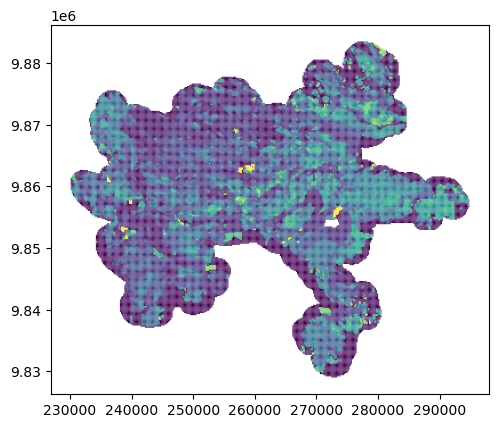

In [16]:
grid_df = grid.compute()
grid_df.plot('m6')

In [76]:
client.close()